# The Diamond Model

## Overview

The diamond model includes two overlapping generations: $\\L_{o}$ and $\\L_{y} = (1 + n)L_{o}$. The 'young' genration provides labor and receives income. The 'old' generation receives capital gains on their savings from the previous period.

The economy consists of one good and a representative firm producing using capital $\\K$ and labor $\\L$ as inputs. The production is $\\F(K,L) = Y$ (or in per-capita terms $\\f(k) = y$. 

Agents in this model make only one decision: how much to $\\s_{t}$ save in the period when they are young. This decision is governed by some utility maximization policy:

\begin{align}
\\max_{s_{t}} U_{t} & = u(w_{t} - s_{t}) + \beta u(R_{t+1}s_{t}) \\
\end{align}

Where $\\s_{t}$ is savings, $\\w_{t}$ is wage income and $\\R_{t+1}$ are capital gains. $\beta$ is a discount factor.

Ultimately the policy function boils down to finding the roots of:

\begin{align}
\beta R_{t+1} u'(R_{t+1}s_{t})  -u'(w_{t} - s_{t}) & = 0 \\
\end{align}

The model has only one state variable - $\\k_{t}$. The policy function determines the law of motion of the state:

\begin{align}
\\k_{t+1} & = \frac{s(A[f(k_{t})-k_{t}\times f'(k_{t})], 1+Af'(k_{t+1})-\delta)}{1+n} \\
\end{align}

The arguments of the $\\s()$ function are expresions for $\\w_{t}$ and $\\R_{t+1}$ respectively. $\delta$ is the depreciation rate and $\\A$ is total factor productivity.

Government actions can also be implemented in this framework. (haven't done this yet though #taxationistheft)


## Implementation

The model is implemented as a standard python class. It takes as inputs model parameters such as the depreciation rate, the initial capital stock and the first generation size.

It also accepts arbitrary production and utility function, as long as their defined as callable instances of a python class. The production function should also have a method for the first derivative with respect to capital per unit of labor, and the utility function should have methods for both first and second derivatives with respect to consumption (illustrated below).

The inputs `A_gen`, `beta_gen` and `n_gen` are designed to allow for stohasticity in the model. They should be classes with a call and expectation methods, as discussed below. When no stohasticity is required they can just return constants all the time (see below).

### Classes for Cobb-Douglas production and logarithmic utility.

These functions are known as the 'canonical' model and are particularly easy for calculaltions of the policy function.

Note the use of the __[SymPy](http://www.sympy.org/en/index.html)__ library for symbolic mathematics.

The element `f` and the return to the method `dk_sym` should be symbolic functions.

In [1]:
from sympy import init_printing
init_printing() 

In [2]:
import numpy as np
import sympy as sp

class cobb_douglas:
    r"""
    A simple class for computing the value of a Cobb-Douglas
    production function and its derivative.
    The parametrezation assumes a per-capita formulation.
    """
    
    def __init__(self, alpha_num):
        self.k, self.alpha = sp.symbols('k alpha')
        self.f = sp.Pow(self.k, self.alpha)
        self.alpha_num = alpha_num

    def __call__(self, k_num):
        values = [(self.k, k_num),(self.alpha, self.alpha_num)]
        res = self.f.subs(values)
        return sp.N(res, chop = True)
    
    def dk_sym(self):
        return sp.diff(self.f, self.k)
    
    def dk(self, k_num):
        values = [(self.k, k_num),(self.alpha, self.alpha_num)]
        res = self.dk_sym().subs(values)
        return sp.N(res, chop = True)
    

class log_utility:
    r"""
    Class for the log utility function. Has a call and derivative
    methods.
    """
    
    def __init__(self):
        self.c = sp.symbols('c')
        self.f = sp.log(self.c)
    
    def __call__(self, c_num):
        values = [(self.c, c_num)]
        res = self.f.subs(values)
        return sp.N(res, chop = True)
    
    def dc_sym(self):
        return sp.diff(self.f, self.c)
    
    def dc(self, c_num):
        values = [(self.c, c_num)]
        res = self.dc_sym().subs(values)
        return sp.N(res, chop = True)
    
    def dc2_sym(self):
        return sp.diff(self.dc_sym(), self.c)
    
    def dc2(self, c_num):
        values = [(self.c, c_num)]
        res = self.dc2_sym().subs(values)
        return sp.N(res, chop = True)
    

Here I have used the `SymPy` `diff` function for automatically computing derivatives. While not necessary for simple functions this illustrates how versatile the library is:

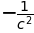

In [3]:
cd = log_utility()
cd.dc2_sym()

### diamondModel class

This is the main class for the model:

In [4]:
import scipy.optimize as opt

class diamondModel:
    r"""
    Implements the overlapping generation model of Diamond.
    Includes methods for period updates.
    """
    
    def __init__(self, K, Lo, dlta, n_gen, A_gen, beta_gen, u, f,):
        """
        TO DO: list required params with short description
        """
        self.K_init, self.Lo_init = K, Lo # to be used when restarting the model
        
        self.K, self.Lo, self.dlta = K, Lo, dlta  
        self.u, self.f = u, f
        self.n_gen, self.A_gen, self.beta_gen = n_gen, A_gen, beta_gen
        
        self.n = self.n_gen()
        self.k = K / (Lo + (1 + self.n)*Lo)
        
        self.update_vars(initial = True)
        
    def reinit(self):
        """
        Method to re-initialize the model to time 0
        """
        self.K = self.K_init
        self.Lo = self.Lo_init
        
        self.n = self.n_gen()
        self.k = self.K / ((1 + self.n)*self.Lo) # divide by the young
        
        self.update_vars(initial = True)
        
        
    def update_vars(self, initial = False):
        """
        Given some inputs calculates additional variables. Namely:
        Ly - 'young' generation
        L - total population
        w - returns to labor
        r - returns to capital
        R - return rate
        y - production per capita
        """
        if not initial:
            self.n = self.n_gen()
            self.K = self.k * (1 + self.n) * self.Lo # reverse update of K since k is
            # now governed by the update rule
        
        self.A = self.A_gen()
        self.beta = self.beta_gen()
        
        self.Ly = (1 + self.n)*self.Lo
        self.L = self.Lo + self.Ly
        
        self.w = self.A * (self.f(self.k) - self.k * self.f.dk(self.k))
        self.r = self.A * self.f.dk(self.k)
        
        self.R = 1 + self.A * self.f.dk(self.k) - self.dlta
        
        self.n_believe = self.n_gen.believe()
        self.A_believe = self.A_gen.believe()
        self.beta_believe = self.beta_gen.believe()
        
        self.y = self.A * self.f(self.k)
    
    def policy_symbolic(self):
        "Finds a functional form for the optimal savings rate"
        s, k, c, n, A, delta, beta, w = sp.symbols('s k c n A delta beta w') 
        def R_tplus1_sym():
            k_tplus1 = s/(1 + n)
            fd_tplus1 = self.f.dk_sym().subs(k, k_tplus1)
            return 1 + A * fd_tplus1 - delta
        
        def savings_foc_sym():
            st = self.u.dc_sym().subs(c, w - s) - beta * R_tplus1_sym() * self.u.dc_sym().subs(c, R_tplus1_sym() * s)
            return st
        
        return sp.solve(savings_foc_sym(), s)
    
    def policy(self, method = "symbolic", er = False):
        "Evaluates the optimal savings rate"
        if method == "symbolic":
            s, k, c, n, A, delta, beta, w = sp.symbols('s k c n A delta beta w')
            
            try:
                values = [(k, self.k),
                          (n, self.n_gen.believe()),
                          (A, self.A_gen.believe()),
                          (delta, self.dlta),
                          (beta, self.beta),
                          (w,self.w)]
                foc = self.policy_symbolic()[0].subs(values)
            except NotImplementedError:
                if er:
                    raise ValueError("Both symbolic and numeric routines failed")
                else:
                    print("Solution method not implemented in sympy. Trying numeric routine isntead")
                    foc = self.policy(method = "numeric", er = True)
            
            return foc
        
        elif method == "numeric":
            
            def savings_foc(s):
                du = self.u.dc(self.w - s) - self.beta * R_tplus1(s) * self.u.dc(R_tplus1(s) * s)
                return sp.N(du)
            
            def du_dc2(s):
                du = -self.u.dc2(self.w - s) - self.beta * R_tplus1(s)**2 * self.u.dc2(R_tplus1(s) * s)
                return sp.N(du)

            def R_tplus1(s):
                k_tplus1 = s/(1 + self.n_believe)
                fd_tplus1 = self.f.dk(k_tplus1)
                return 1 + self.A_believe * fd_tplus1 - self.dlta
            
            try:
                solution = opt.newton(savings_foc, 0.5, maxiter=500, fprime=du_dc2) 
                #solution = opt.brentq(savings_foc, 0, self.w, maxiter=500)
            except RuntimeError:
                if er:
                    raise ValueError("Both symbolic and numeric routines failed")
                else:
                    print("Alogrithm failed to converge trying symbolic instead")
                    solution = self.policy(method = "symbolic", er = True)

            return solution
        
    def steady_state(self):
        # will do it some other time ʕ•ᴥ•ʔ
        pass
    
    def update(self, method = "symbolic"):
        "Advances time with 1 period"
        self.k = self.policy(method = method)/(1 + self.n)
        self.Lo = self.Ly
        self.update_vars()
        
    def generate_sequence(self, var = "k", t = 5, method = "symbolic", reinit = True):
        "Generates a time sequence"
        path = []
        for i in range(t):
            path.append(getattr(self, var))
            self.update(method = method)
        if reinit:
            self.reinit()
        return path

Most of the work is done by the `policy` method. Note that this method has both a symbolic and a fall-back numerical implementation. The latter is done via a simple Newton-Raphson solver from the `optimize` module.

### Example of a canonical instance of the class

In [5]:
class genconst:
    def __init__(self, const):
        self.const = const
    def __call__(self):
        return self.const
    def believe(self):
        return self.const

model = diamondModel(
    K = 3, 
    Lo = 5, 
    dlta = 0.02, 
    n_gen = genconst(0.05), 
    A_gen = genconst(2), 
    beta_gen = genconst(0.87),
    u = log_utility(), 
    f = cobb_douglas(0.33)
)


Here the class `genconst` is just a dummy that always returns the same value (i.e. no stohasticity in the model and no need for believe-formation).

Here is an illustration of computing the policy function. Note that the symbolic method returns the expected theoretical result. Also in this case both the numeric and symbolic solvers provide a exact solution

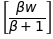

In [6]:
model.policy_symbolic()

In [7]:
model.beta/(1 + model.beta) * model.w # exact solution for the log-utility case

In [8]:
model.policy(method = "symbolic")

In [9]:
model.policy(method = "numeric") 

Now the `generate_sequence` method (which just calls `update` over and over) can be used to examine the dynamics.

In [10]:
model.generate_sequence("L", 3)

### Plotting

This will be easier graphically:

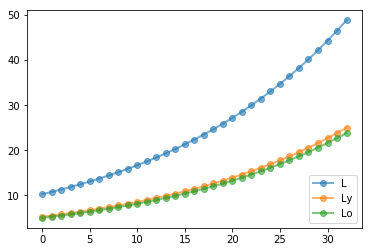

In [11]:
import matplotlib.pyplot as plt

def plot_sequence(mod, vars = "k",  t = 10, method = "symbolic"):
        fig, ax = plt.subplots()
        for var in vars:
            lb = var
            ax.plot(mod.generate_sequence(var, t, method), 'o-', lw=2, alpha=0.6, label=lb)            
        ax.legend(loc='lower right')
        plt.show()

plot_sequence(model, ["L","Ly","Lo"], 33)

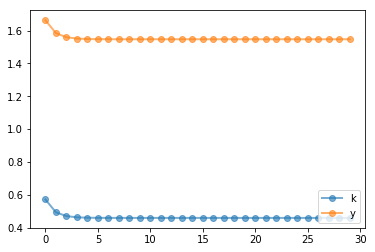

In [12]:
plot_sequence(model, ["k","y"], 30)

It seems that the model converges to a steady state rather quickly.

### Comparing different starting parameters

Comparing different starting capital stocks:

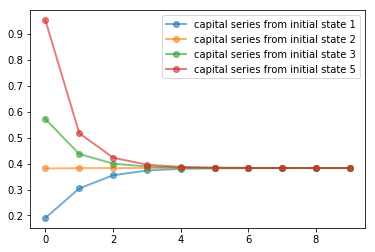

In [13]:
baseline = diamondModel(
    K = 3, 
    Lo = 5, 
    dlta = 0.02, 
    n_gen = genconst(0.05), 
    A_gen = genconst(2), 
    beta_gen = genconst(0.7),
    u = log_utility(), 
    f = cobb_douglas(0.33)
)

Ks = [1,2,3,5]
T = 10

fig, ax = plt.subplots()
for K in Ks:
    baseline.K_init = K
    baseline.reinit()
    lb = 'capital series from initial state {}'.format(baseline.K_init)
    ax.plot(baseline.generate_sequence("k", T), 'o-', lw=2, alpha=0.6, label=lb)

ax.legend(loc='upper right')
plt.show()


Different TFP:

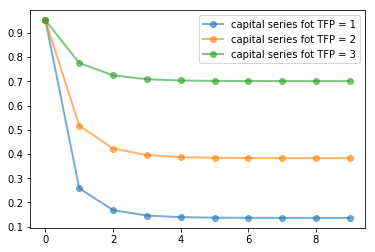

In [14]:
As = [genconst(1),genconst(2),genconst(3)]
T = 10

fig, ax = plt.subplots()
for A in As:
    baseline.A_gen = A
    baseline.reinit()
    lb = 'capital series fot TFP = {}'.format(baseline.A)
    ax.plot(baseline.generate_sequence("k", T), 'o-', lw=2, alpha=0.6, label=lb)

ax.legend(loc='upper right')
plt.show()

### Introducing Shocks

Now we can introduce some randomness in the economy. Here this is done with the `A_gen` attribute.

The class `capital_shocker` just provides a random draw from a set of possible values of `A` for each period.

I have assumed that agents expect the value of `A` for next period to be the average of all possible outcomes of `A_gen` (the `believe` method below. This doesn't matter for the canonical case, as expected output in the next period cancels out of the policy function, but maybe relevant with a different utility function.

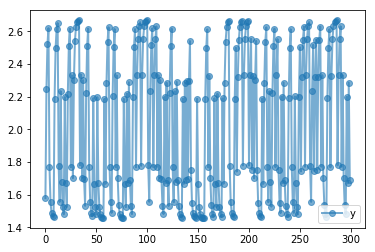

In [15]:
from random import randint

class capital_shocker:
    def __init__(self, sample_space):
        self.sample_space = sample_space
        self.n_spaces = len(sample_space)
    def __call__(self):
        return self.sample_space[randint(0,self.n_spaces-1)]
    def believe(self):
        return np.mean(self.sample_space)

model = diamondModel(
    K = 100, 
    Lo = 100, 
    n_gen = genconst(0.05), 
    A_gen = capital_shocker([2,3]), 
    dlta = 0.02, 
    u = log_utility(), 
    f = cobb_douglas(0.33), 
    beta_gen = genconst(0.7)
)

plot_sequence(model, "y", 300)

### Markov process shocks

More reasonably the shock can be a markov process.

Here the class `markov_shocker` has its own state which is used to generate the next value given the transition matrix `P`.

For the beliefs I assume that the agents don't know the form of the generating process `A_gen`, but have observed a large number of realisations from it. The expectation is just formed as the average of these observations (again ends up being irrelevant for the canonical case).

In [16]:
import quantecon as qe

P = [[0.4, 0.6], [0.2, 0.8]]
mc = qe.MarkovChain(P)

class markov_shocker:
    
    def __init__(self, P, state_space, nobs = 100):
        self.mc = qe.MarkovChain(P)
        self.state_space = state_space
        self.state = mc.simulate(ts_length=1)[0]
        self.nobs = nobs
        self.cachebelieve = self.believe(cache = False)
        
    def __call__(self):
        new_state = self.mc.simulate(ts_length=2, init=self.state)
        self.state = new_state[1]
        return self.state_space[self.state]
    
    def believe(self, cache = True):
        if cache:
            return self.cachebelieve
        else:
            statecp = self.state
            X = np.empty(self.nobs, dtype=float)
            for t in range(self.nobs):
                X[t] = self() 
            self.state = statecp
            return np.mean(X)

MC = markov_shocker(P, (2,3))

X = np.empty(8, dtype=int)
for t in range(8):
        X[t] = MC()
        
X

array([3, 3, 3, 3, 2, 3, 3, 3])

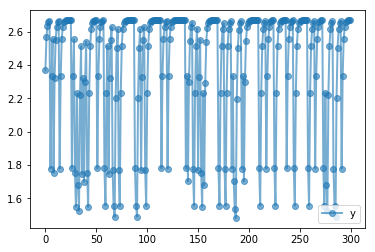

In [17]:
model = diamondModel(
    K = 100, 
    Lo = 100, 
    n_gen = genconst(0.05), 
    A_gen = MC, 
    dlta = 0.02, 
    u = log_utility(), 
    f = cobb_douglas(0.33), 
    beta_gen = genconst(0.7)
)

plot_sequence(model, "y", 300)

If we want to examine the histogram of steady state `k`:

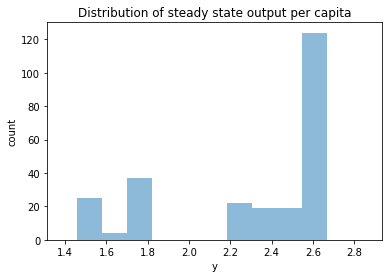

In [18]:
import math

seq = model.generate_sequence("y", 300)[50:]
seq = np.array(seq, dtype=float)

plt.xlim([min(seq)*.9, max(seq)*1.1])

plt.hist(seq, alpha=0.5)
plt.title('Distribution of steady state output per capita')
plt.xlabel('y')
plt.ylabel('count')

plt.show()

Autocorrelation plot

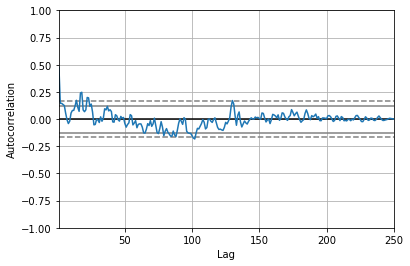

In [19]:
import pandas as pd
from pandas.plotting import autocorrelation_plot

seq = model.generate_sequence("y", 300)[50:]
seq = pd.Series(seq)

plt.figure()
autocorrelation_plot(seq)

plt.show()

### Different utility and production functions

Much of the code above would be unjustified if only looking at the cannonical case. This section illustrates the use of the class with different utility and production functions (not particularly useful ones but the point is to show that the iplementation is agnostic to the particular function form).

In [45]:
class alternative_f:
    r"""
    An alternative production function.
    """
    
    def __init__(self, alpha_num, epsilon_num):
        self.k, self.alpha, self.epsilon = sp.symbols('k alpha epsilon')
        #self.f = np.power(self.alpha*self.k + 1 - self.alpha, self.epsilon/(self.epsilon - 1))
        self.f = np.power(self.epsilon*sp.log(self.k) + 1, self.alpha)
        self.alpha_num, self.epsilon_num = alpha_num, epsilon_num

    def __call__(self, k_num):
        values = [(self.k, k_num),(self.alpha, self.alpha_num),(self.epsilon, self.epsilon_num)]
        res = self.f.subs(values)
        return sp.N(res)
    
    def dk_sym(self):
        return sp.diff(self.f, self.k)
    
    def dk(self, k_num):
        values = [(self.k, k_num),(self.alpha, self.alpha_num),(self.epsilon, self.epsilon_num)]
        res = self.dk_sym().subs(values).evalf(chop = True)
        return sp.N(res)
    

class alternative_u:
    r"""
    An alternative utility function
    """
    
    def __init__(self, gamma_num):
        self.c, self.gamma = sp.symbols('c gamma')
        self.f = (np.power(self.c, 1-self.gamma) - 1)/(1 - self.gamma)
        self.gamma_num = gamma_num
    
    def __call__(self, c_num):
        values = [(self.c, c_num),(self.gamma, self.gamma_num)]
        res = self.f.subs(values)
        return sp.N(res)
    
    def dc_sym(self):
        return sp.diff(self.f, self.c)
    
    def dc(self, c_num):
        values = [(self.c, c_num),(self.gamma, self.gamma_num)]
        res = self.dc_sym().subs(values)
        return sp.N(res)
    
    def dc2_sym(self):
        return sp.diff(self.dc_sym(), self.c)
    
    def dc2(self, c_num):
        values = [(self.c, c_num),(self.gamma, self.gamma_num)]
        res = self.dc2_sym().subs(values)
        return sp.N(res)
    

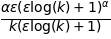

In [46]:
af = alternative_f(0.33, 0.5)
af.dk_sym()

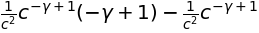

In [47]:
ac = alternative_u(0.5)
ac.dc2_sym()

Note that now the expectation forming process matters because the return in the next period does not cancel out of the policy function.

Also as the functions become more convoluted the probability that `SymPy` can deal with them decreases. Therefore numeric routines are used instead.

Also note that depending on the starting parameters the newton-raphson algorithm may not converge or might end up finding complex roots.

In [48]:
alternativeModel = diamondModel(
    K = 3, 
    Lo = 5, 
    dlta = 0.02, 
    n_gen = genconst(0.05), 
    A_gen = genconst(2), 
    beta_gen = genconst(0.7),
    u = alternative_u(0.5), 
    f = alternative_f(0.33, 0.4)
)

alternativeModel.policy(method = "symbolic")

Solution method not implemented in sympy. Trying numeric routine isntead


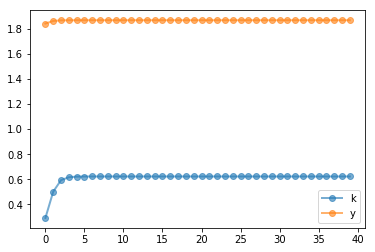

In [49]:
alternativeModel = diamondModel(
    K = 3, 
    Lo = 5, 
    dlta = 0.02, 
    n_gen = genconst(0.05), 
    A_gen = genconst(2), 
    beta_gen = genconst(0.7),
    u = alternative_u(0.5), 
    f = alternative_f(0.33, 0.4)#cobb_douglas(0.33)
)

plot_sequence(alternativeModel, ["k","y"], 40, "numeric")


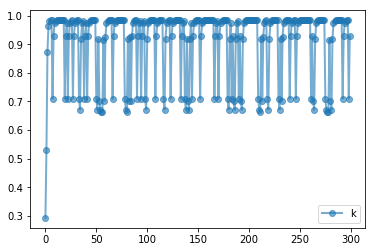

In [50]:
alternativeModel = diamondModel(
    K = 3, 
    Lo = 5, 
    dlta = 0.02, 
    n_gen = genconst(0.05), 
    A_gen = MC, 
    beta_gen = genconst(0.7),
    u = alternative_u(0.5), 
    f = alternative_f(0.33, 0.4)#cobb_douglas(0.33)
)

plot_sequence(alternativeModel, "k", 300, "numeric")

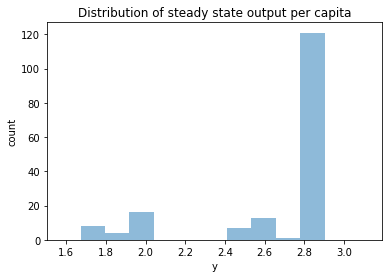

In [32]:
seq = alternativeModel.generate_sequence("y", 200, method = "numeric")[30:]
seq = np.array(seq, dtype=float)

plt.xlim([min(seq)*.9, max(seq)*1.1])

plt.hist(seq, alpha=0.5)
plt.title('Distribution of steady state output per capita')
plt.xlabel('y')
plt.ylabel('count')

plt.show()